SED for 70 Oph B as a proxy for NGTS 10 - lots of it can come from STARCAT and LOWLIB 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/'
starfile ='h_hd165341_uvsum_1x_51779_spc.fits'
ngslfile =  'h_stis_ngsl_hd165341_v1.fits' #not in lowlib for some reason~

In [5]:
tspec = fits.getdata('{}hlsp/{}'.format(path, starfile), 1)[0]
w_uv, f_uv, e_uv = tspec['WAVE'], tspec['FLUX'], tspec['ERROR']

ngspec = fits.getdata('{}hlsp/{}'.format(path, ngslfile), 1)
w_opt, f_opt, e_opt = ngspec['WAVELENGTH'], ngspec['FLUX_UNRED'], ngspec['STATERR']


(1e-14, 1e-10)

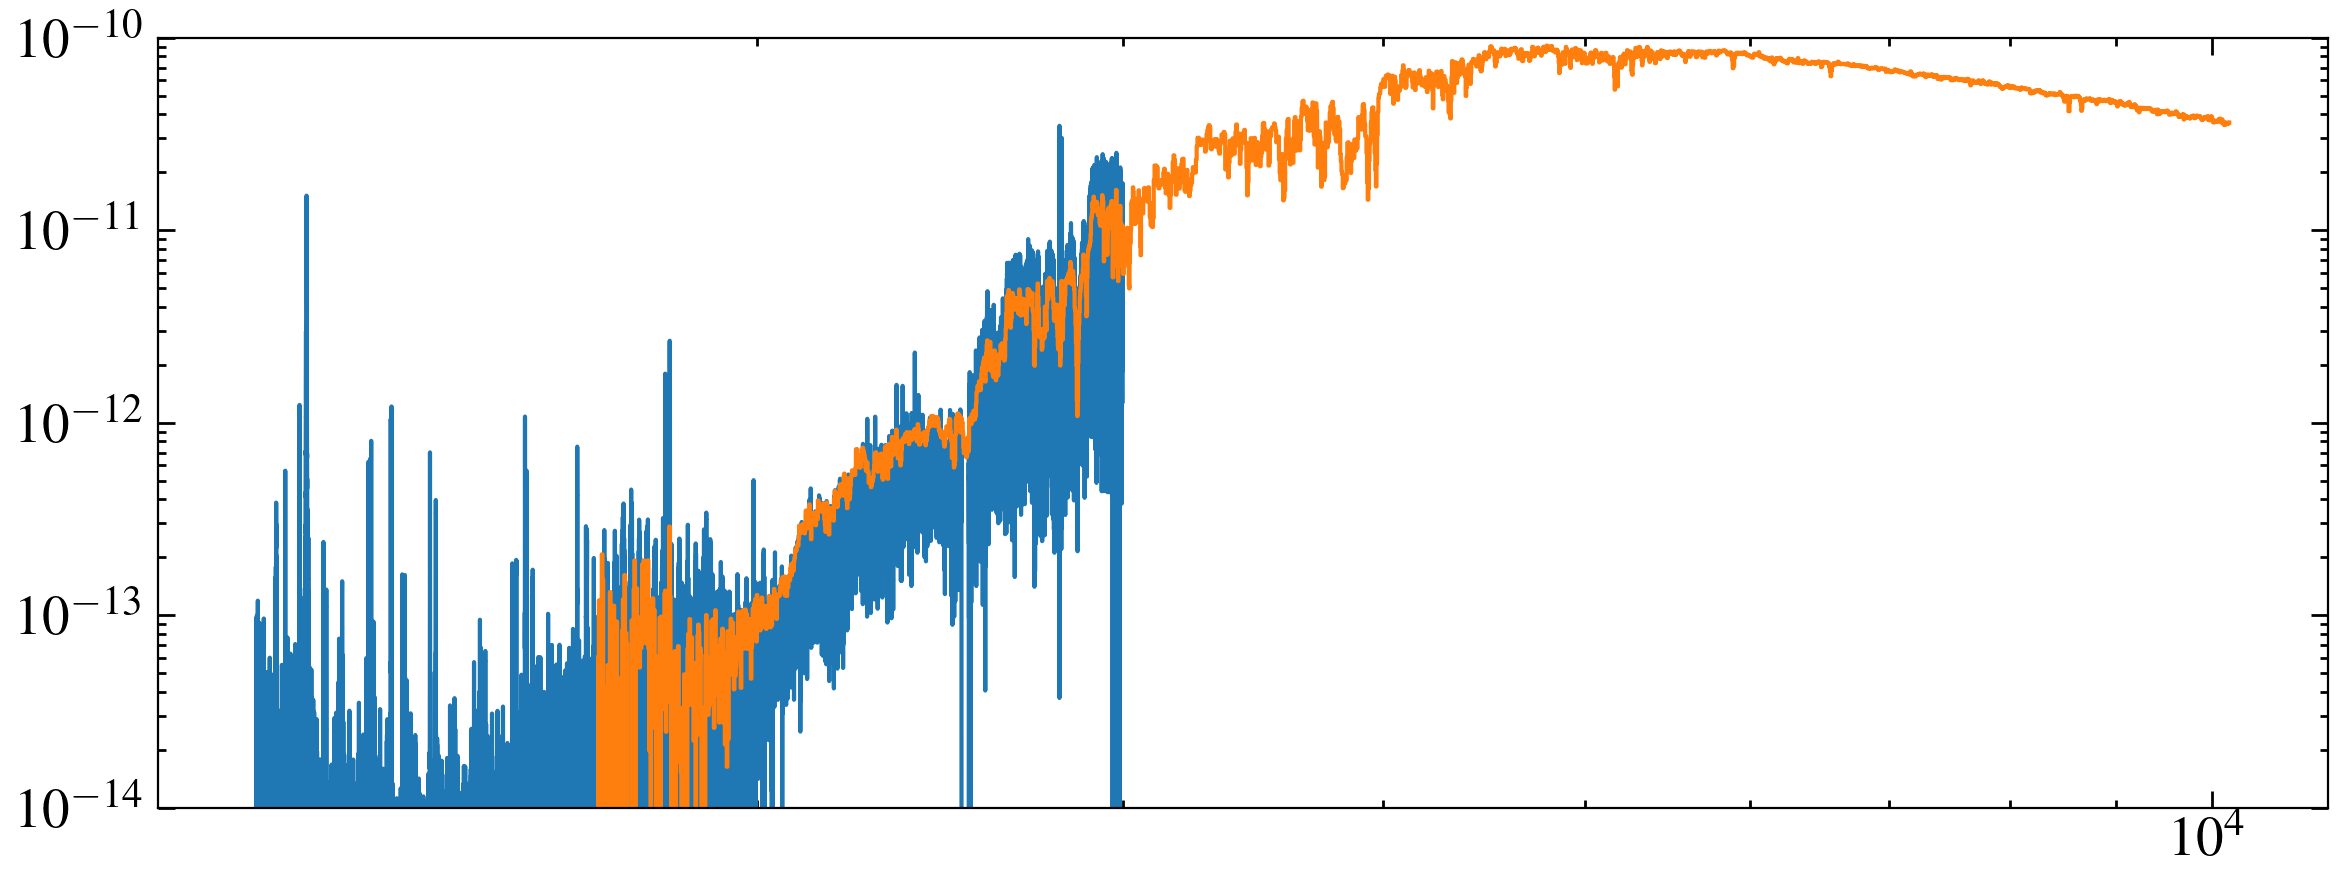

In [6]:
fig, ax = plt.subplots()

ax.step(w_uv, f_uv, where='mid')
ax.step(w_opt, f_opt, where='mid')
# ax.step(w_opt, ngspec['FLUX'], where='mid')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-14, 1e-10)

(0.0, 5e-11)

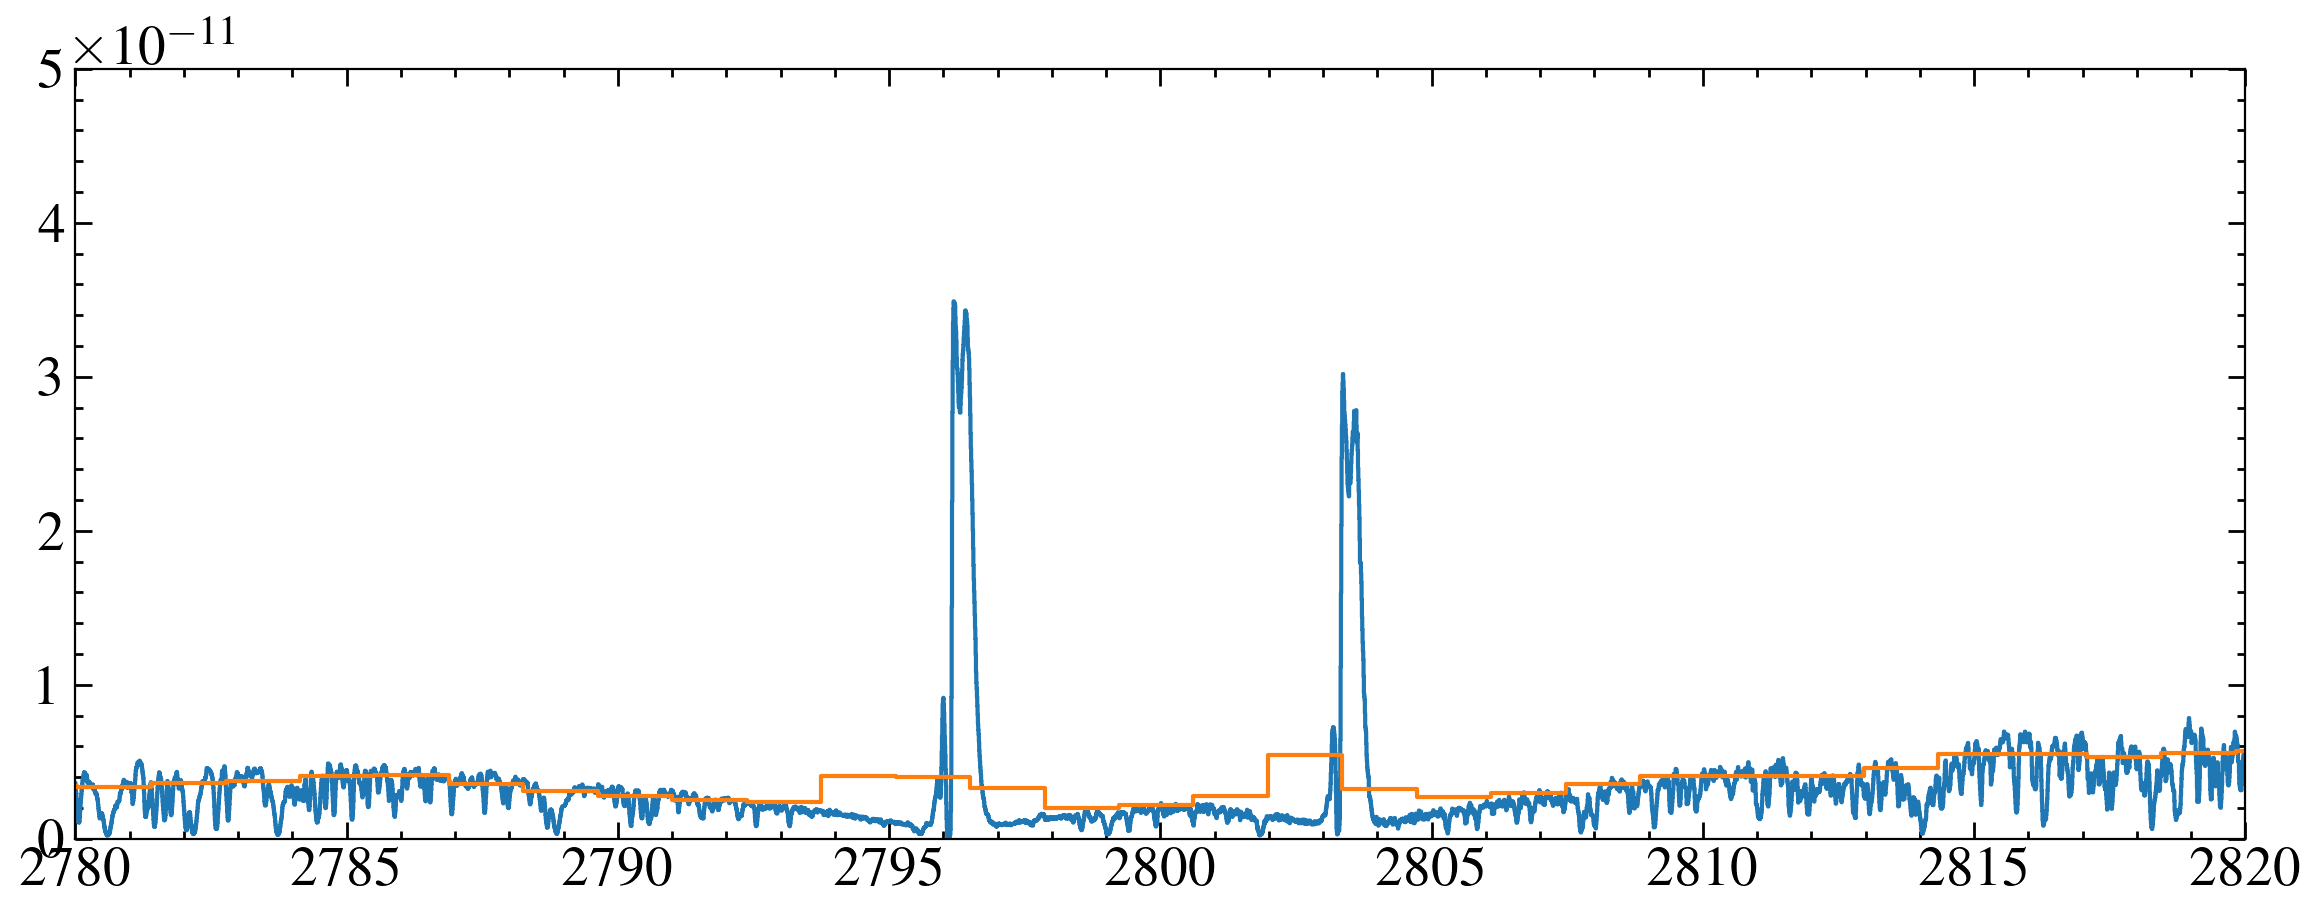

In [7]:
fig, ax = plt.subplots()

ax.step(w_uv, f_uv, where='mid')
ax.step(w_opt, f_opt, where='mid')
# ax.step(w_opt, ngspec['FLUX'], where='mid')

# ax.set_yscale('log')
# ax.set_xscale('log')

# ax.set_ylim(1e-14, 1e-10)
ax.set_xlim(2780, 2820)
ax.set_ylim(0, 5e-11)

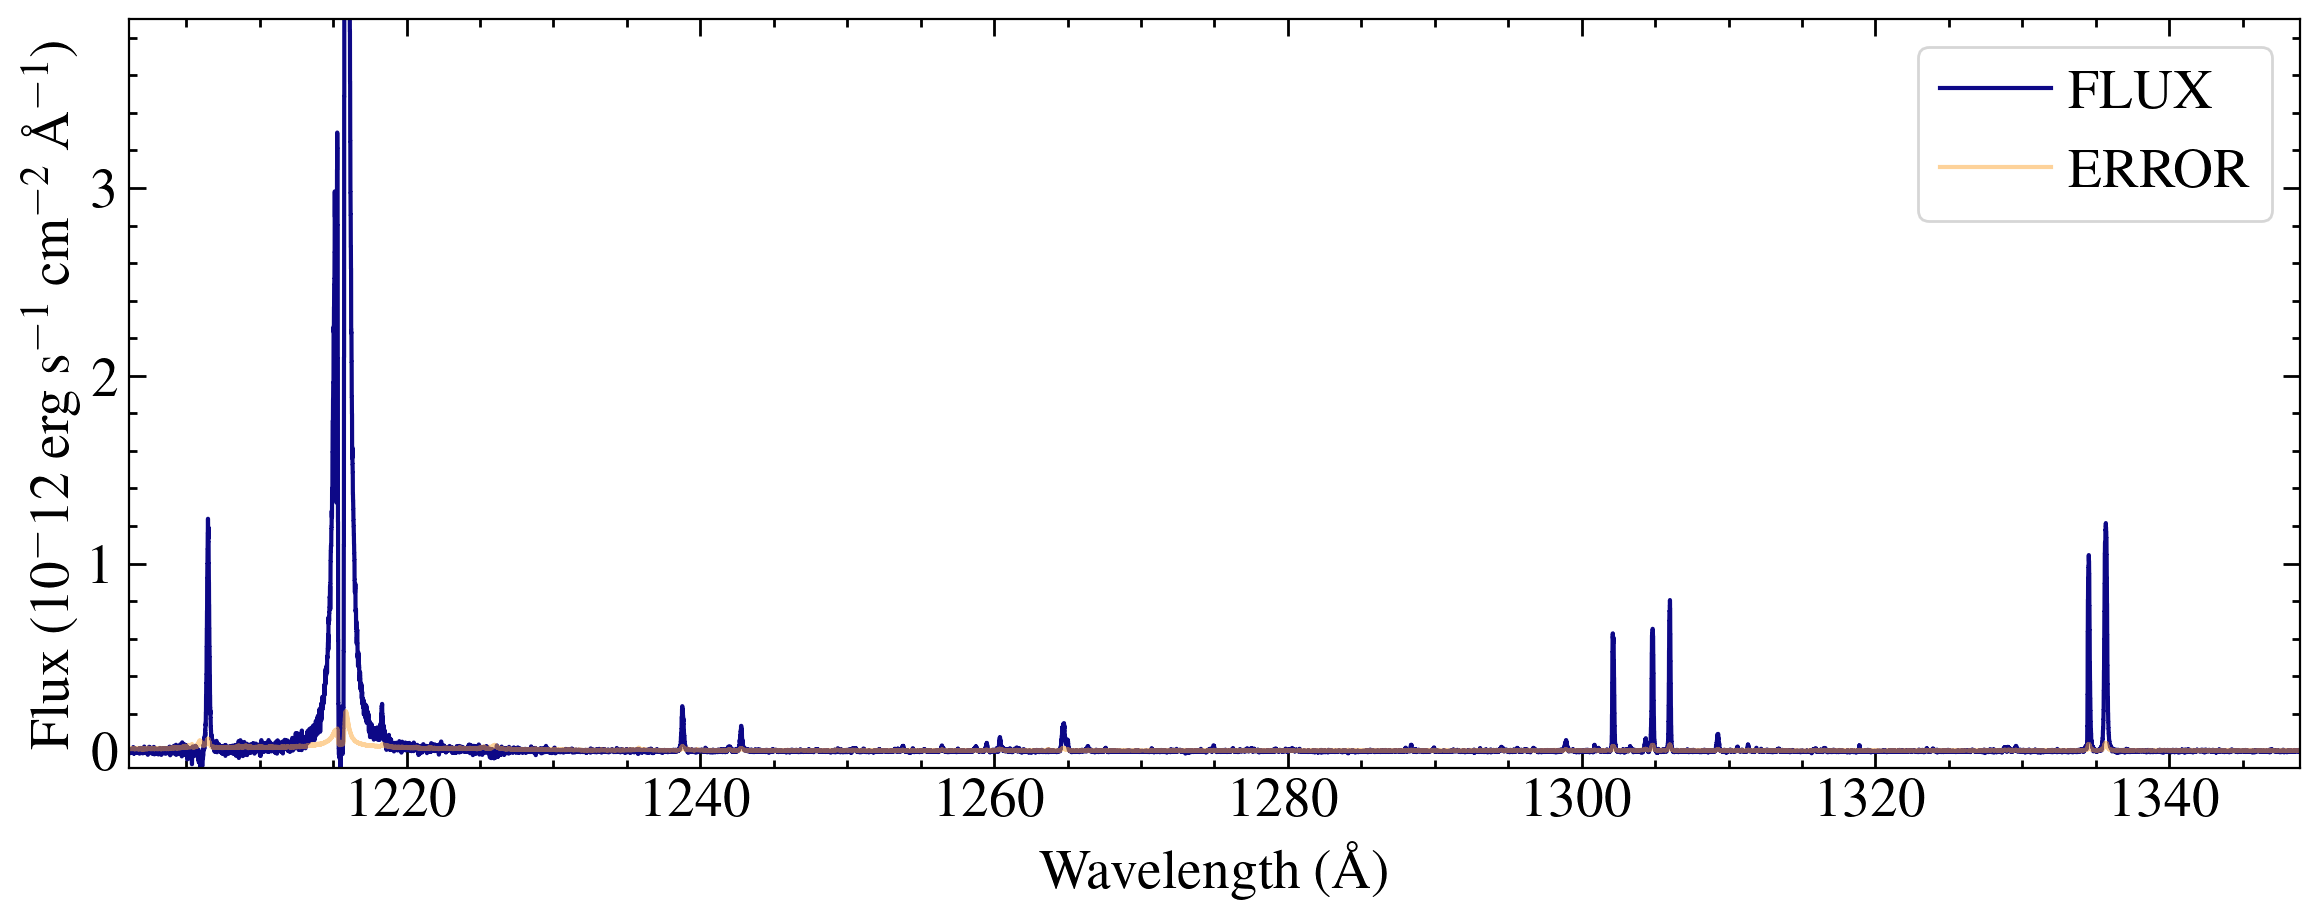

In [8]:


fig, ax = plt.subplots(figsize=(12, 5))

scale = 1e12

ax.step(w_uv, f_uv*scale, where='mid', label='FLUX', c= plt.cm.plasma(0))
ax.step(w_uv, e_uv*scale, where='mid', alpha=0.5, label ='ERROR', c= plt.cm.plasma(0.8))

ax.set_ylim(-0.09, 3.9)
ax.set_xlim(1201.1, 1348.9)
# ax.set_ylim(-0.09, 16.9)
# ax.set_xlim(1213.1, 1218.9)


ax.legend(frameon=True)

ax.set_ylabel('Flux (10$^-12$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')

ax.set_xlabel('Wavelength (\AA)')



fig.tight_layout()

Add Starcat already implemented, could make an add lowlib/ngsl routine later.

Unclear if the data is from A or B, checking all the data to see if there are two different stars

In [9]:
hasp = glob.glob('{}*cspec*fits'.format(path))
hasp

['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/hst_8280_stis_hd165341_e140m-e230m-e230h_o5bn05_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/hst_8280_stis_hd165341_e140m-e230m-e230h_o5bn_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/hst_8280_stis_hd165341_e140m_o5bn_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/hst_8280_stis_hd165341_e230h_o5bn05_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/hst_8280_stis_hd165341_e230h_o5bn_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/hst_8280_stis_hd165341_e230m_o5bn05_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/hst_8280_stis_hd165341_e230m_o5bn_cspec.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/hst_8280_stis_hd165341_e140m_o5bn05_cspec.fits']

In [10]:
x1ds = glob.glob('{}*x1d.fits'.format(path))
x1ds

['/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/o5bn05030_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/o5bn05010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/o5bn05020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/o5bn05040_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/o5bn05050_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/meats/hst/70ophB/70ophA/o5bn05060_x1d.fits']

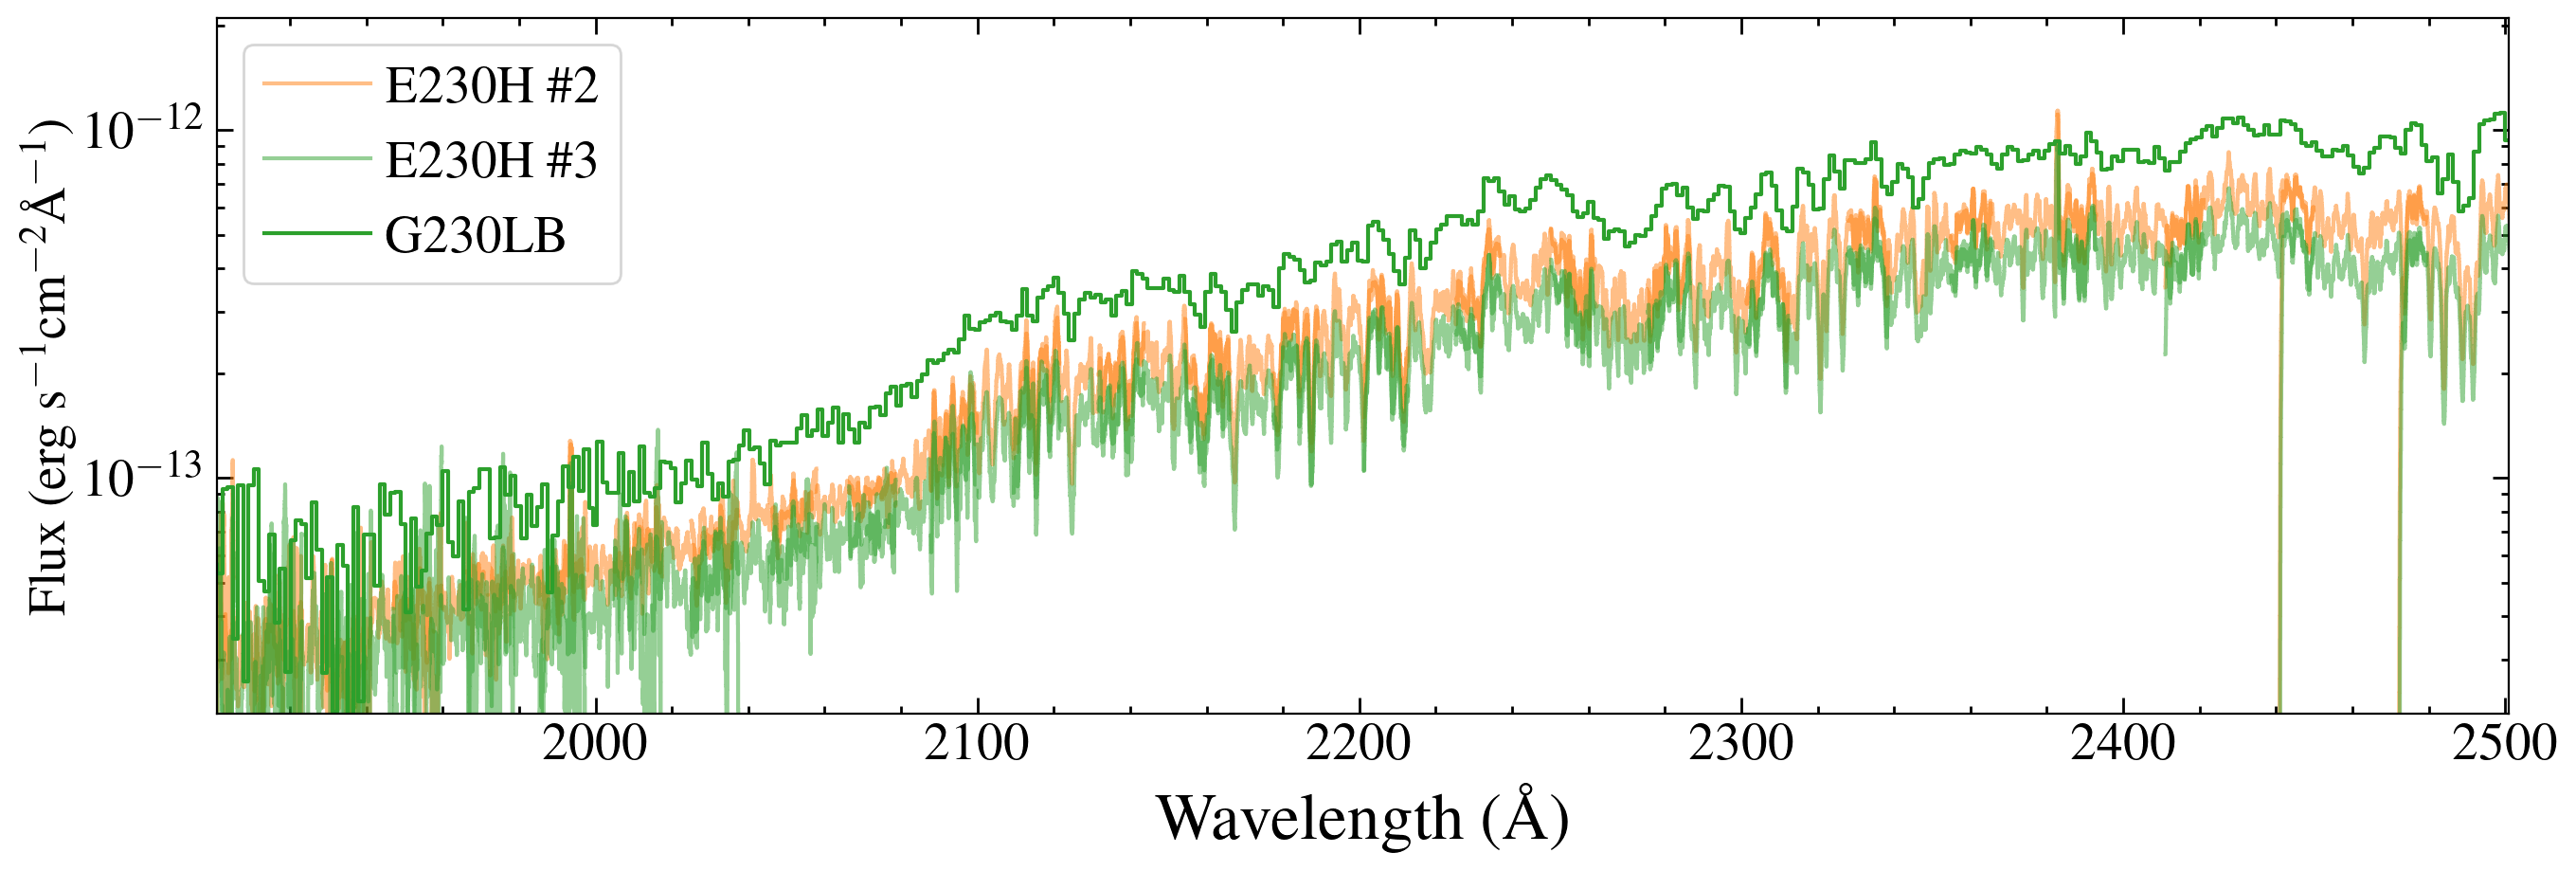

In [11]:
fig, ax = plt.subplots()
nclip=20


for i, x in enumerate(x1ds):
    if fits.getheader(x, 0)['OPT_ELEM'] in ['E230M']:
        dt = fits.getdata(x, 1)
        for data in dt:
            w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
            mask = w >1160
            f = convolve(f, Box1DKernel(20))
            
            w, f, e, = w[mask], f[mask], e[mask]
            ax.step(w[nclip:-nclip], f[nclip:-nclip], where='mid', alpha=0.5, c='C{}'.format(i), label = 'E230H \#{}'.format(i+1))
ax.set_yscale('log')
# ax.set_xscale('log')
ax.step(w_opt, f_opt, where='mid', label = 'G230LB', c='C2')
ax.set_xlim(1901, 2501)


ax.set_ylim(2.1e-14, 2.1e-12)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), frameon=True)

ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)', size=25)

fig.tight_layout()
# ax.set_xlim(2790, 2810)

Flux calibration. Make models of the two stars and see how big the NUV difference should be? Params from https://iopscience.iop.org/article/10.1088/0004-637X/757/2/112

In [12]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)


massA = 0.846
teffA = 5407
teff_eA = 52
radiusA = 0.8310

massB = 0.698
teffB = 4393
teff_eB = 149
radiusB = 0.6697

distance = 5.113

save_path = 'models/'
# star = 'toi-134'
gA = ((G*massA*M)/(radiusA*R)**2).to(u.cm/u.s**2)
gB = ((G*massB*M)/(radiusB*R)**2).to(u.cm/u.s**2)
# print(gA, gB)
# g = 4.04
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

A_star_params = {'Teff': teffA, 'Teff_e':teff_eA,  'logg': np.log10(gA.value), 'FeH': 0.00, 'aM': 0, 'Radius':radiusA*u.R_sun, 'Distance':distance*u.pc}
# pwA, pfA, peA = pp.make_phoenix_spectrum('70_oph_A', save_path, repo, A_star_params, save_ecsv=True, plot=True, make_error=True)
pdataA = Table.read('models/{}_phoenix_interpolated.ecsv'.format('70_oph_A'))
pwA, pfA, peA = pdataA['WAVELENGTH'], pdataA['FLUX'], pdataA['ERROR']
normfacA = ((radiusA*R)/((distance*u.pc).to(u.m)))**2

B_star_params = {'Teff': teffB, 'Teff_e':teff_eB,  'logg': np.log10(gB.value), 'FeH': 0.00, 'aM': 0, 'Radius':radiusB*u.R_sun, 'Distance':distance*u.pc}
# pwB, pfB, peB = pp.make_phoenix_spectrum('70_oph_B', save_path, repo, B_star_params, save_ecsv=True, plot=True, make_error=True)
pdataB = Table.read('models/{}_phoenix_interpolated.ecsv'.format('70_oph_B'))
pwB, pfB, peB = pdataB['WAVELENGTH'], pdataB['FLUX'], pdataB['ERROR']
normfacB = ((radiusB*R)/((distance*u.pc).to(u.m)))**2

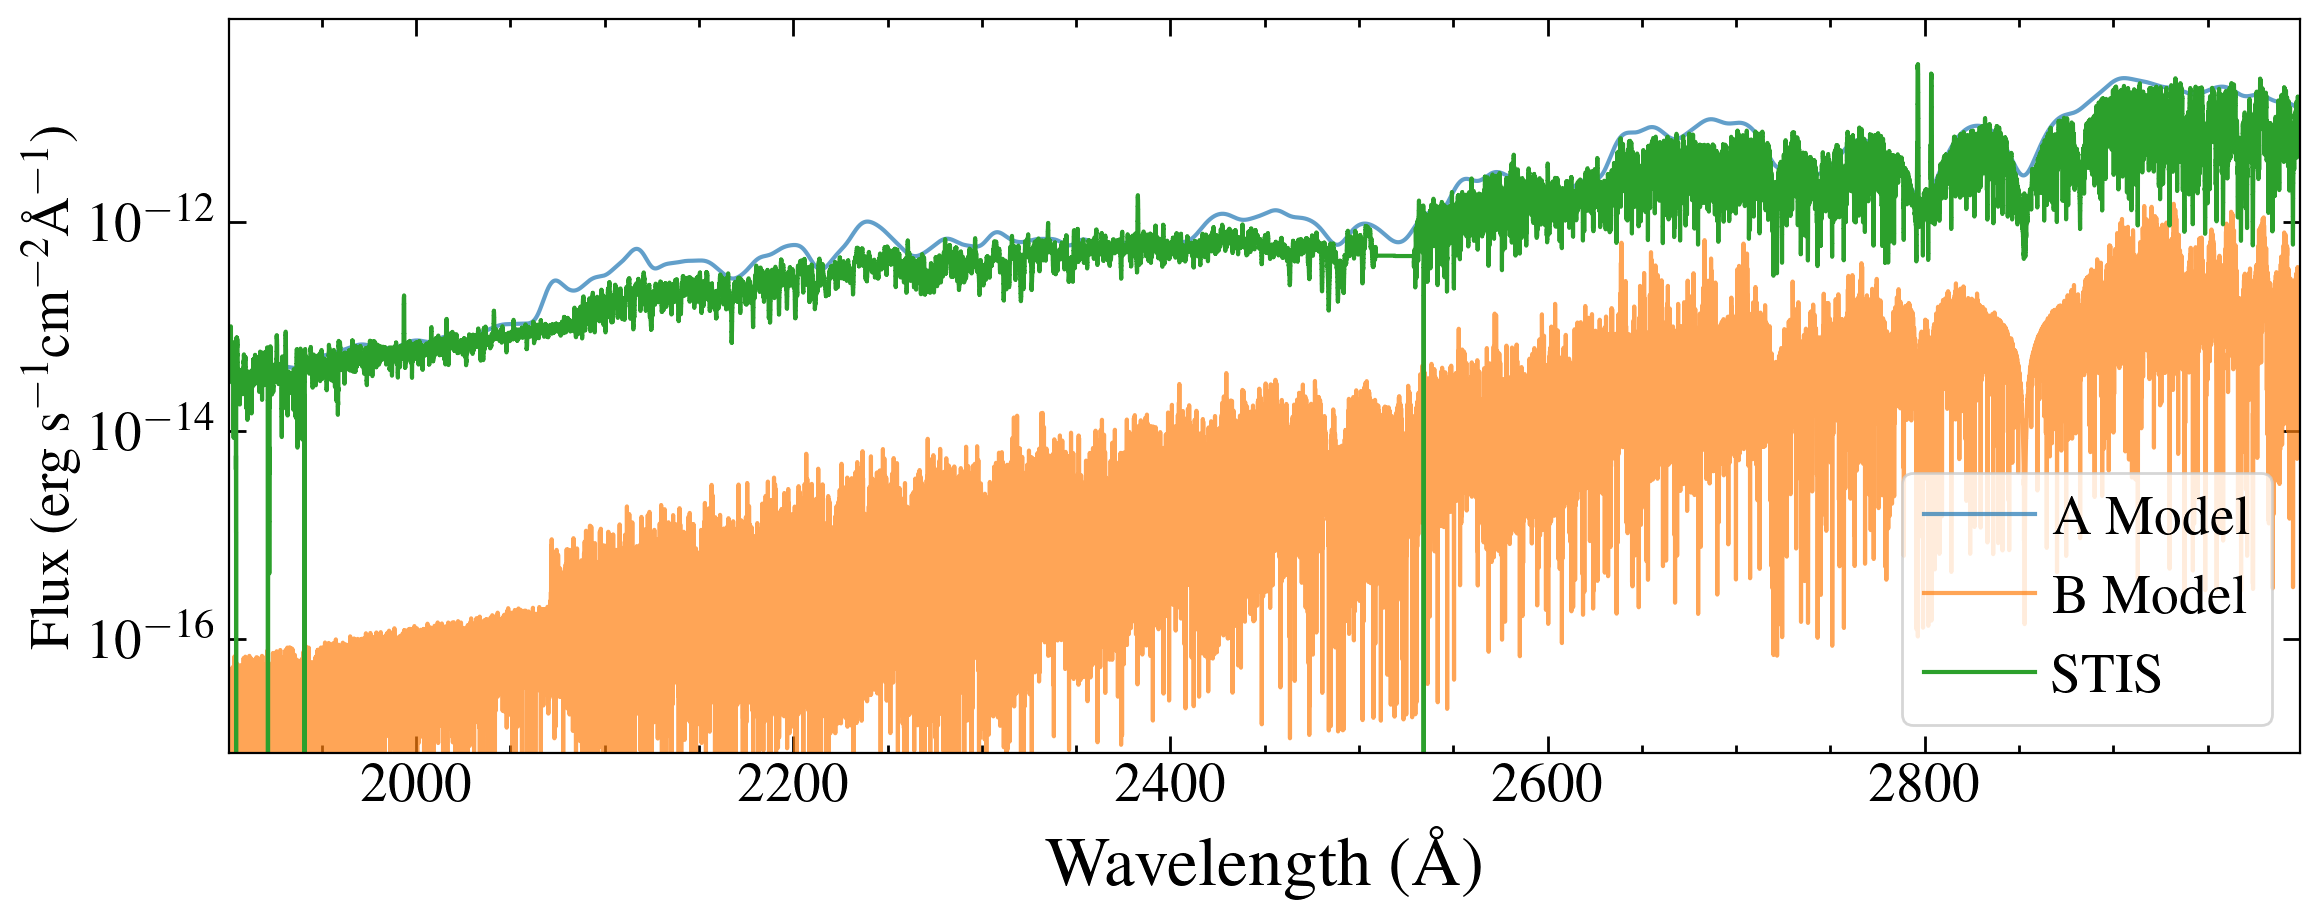

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))

pwAi, pfAi = pp.smear(pwA, pfA, 500)


# ax.plot(pwA, pfA*normfacA, alpha=0.7, label = 'A Model')
ax.plot(pwAi, pfAi*normfacA, alpha=0.7, label = 'A Model')
ax.plot(pwB, pfB*normfacB, alpha=0.7, label = 'B Model')

ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(1901, 2999)
# ax.set_xlim(2000, 3000)
ax.set_ylim(8.1e-18, 8.9e-11)
f_uvi = convolve(f_uv, Box1DKernel(20))
ax.step(w_uv, f_uvi, where='mid', label='STIS')
# ax.step(w_opt, f_opt, where='mid')

ax.legend(frameon=True)

ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)', size=25)

fig.tight_layout()

A then.

(0.0, 2e-11)

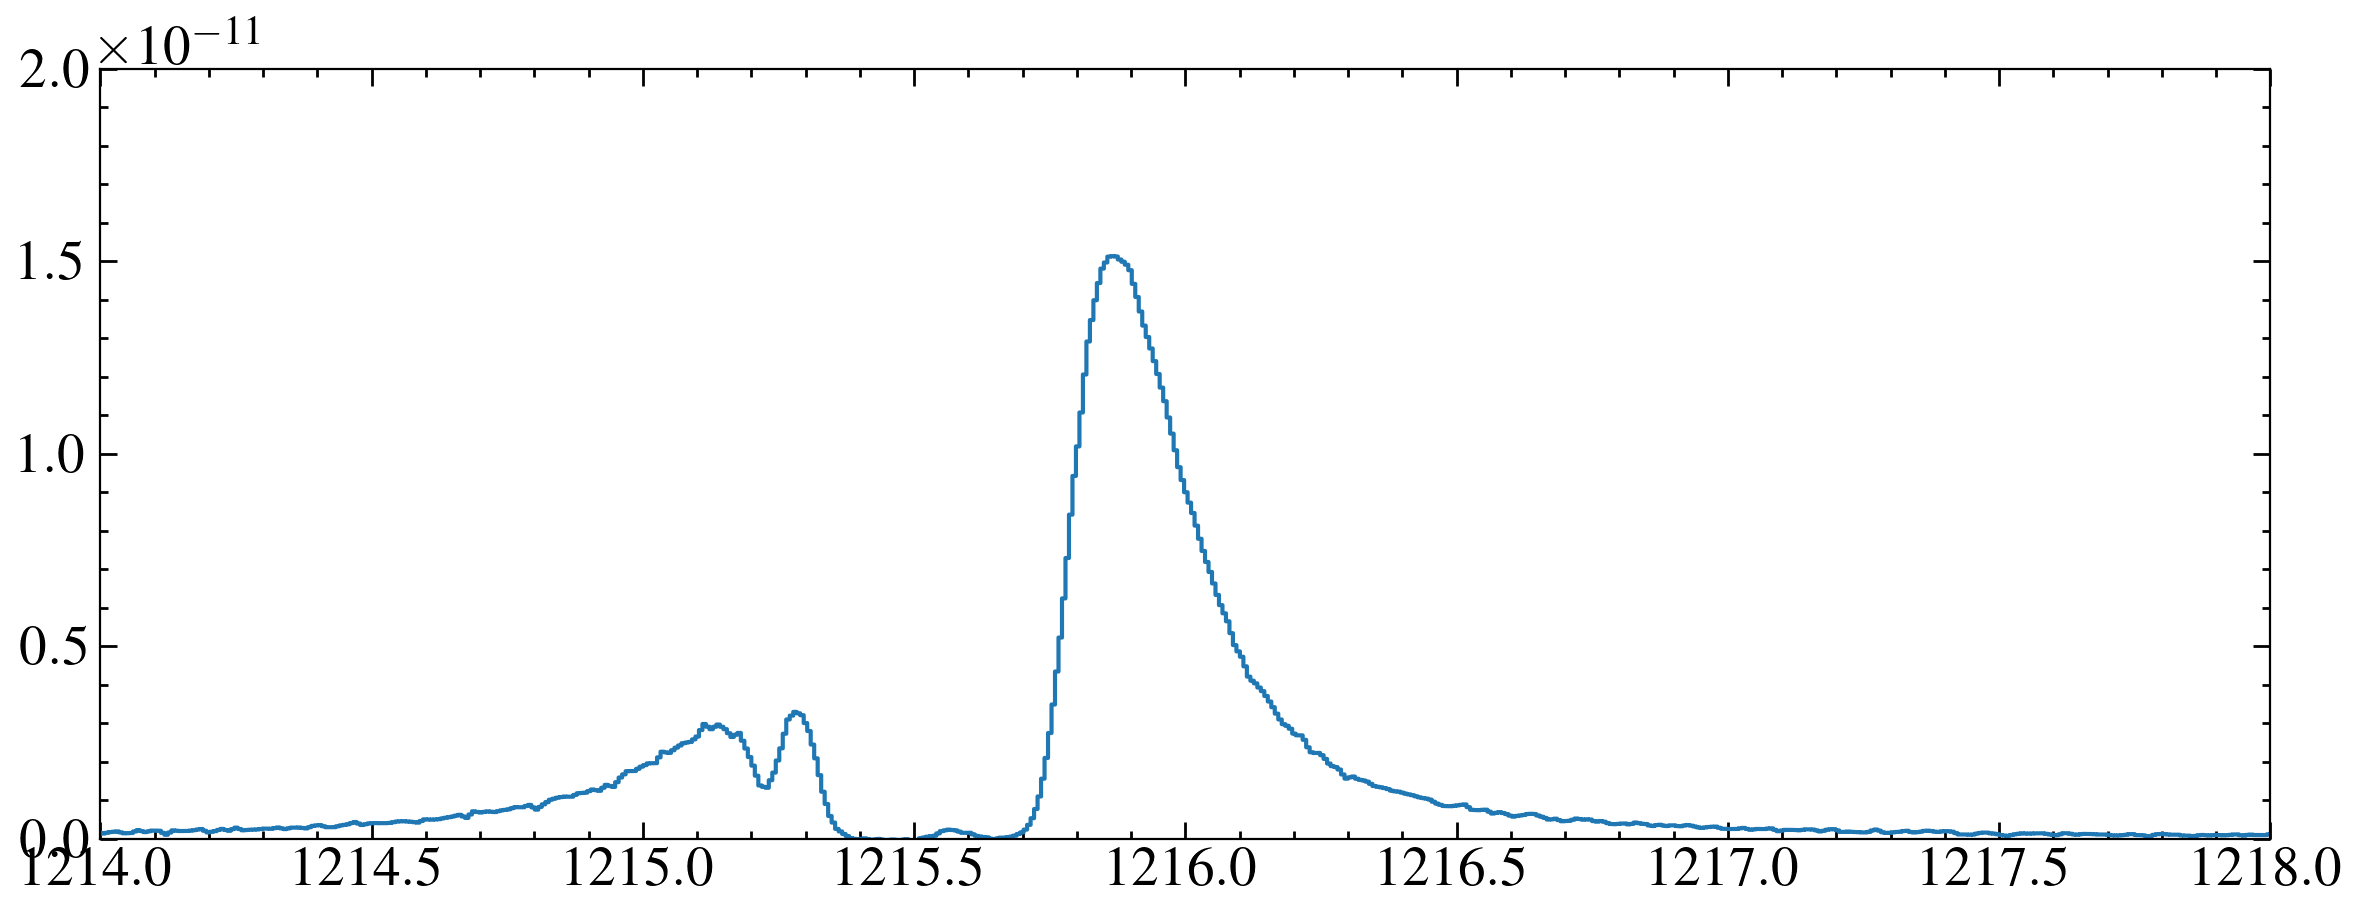

In [14]:
fig, ax = plt.subplots()

ax.step(w_uv, f_uv, where='mid', label='STIS')

# ax.set_xlim(1160, 1800)
# ax.set_xlim(1546, 1552)
ax.set_xlim(1214, 1218)
# ax.set_ylim(0, 2e-12)
ax.set_ylim(0, 2e-11)